In [2]:
import os
import json
import numpy as np

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda

from glob import glob
import shutil
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! unzip ./drive/MyDrive/poly.zip -d ./zip_data


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./zip_data/polyp/720401.jpg  
  inflating: ./zip_data/polyp/72050.jpg  
  inflating: ./zip_data/polyp/720501.jpg  
  inflating: ./zip_data/polyp/720601.jpg  
  inflating: ./zip_data/polyp/720650.jpg  
  inflating: ./zip_data/polyp/720950.jpg  
  inflating: ./zip_data/polyp/721001.jpg  
  inflating: ./zip_data/polyp/721020.jpg  
  inflating: ./zip_data/polyp/721050.jpg  
  inflating: ./zip_data/polyp/721101.jpg  
  inflating: ./zip_data/polyp/721120.jpg  
  inflating: ./zip_data/polyp/721150.jpg  
  inflating: ./zip_data/polyp/72120.jpg  
  inflating: ./zip_data/polyp/721220.jpg  
  inflating: ./zip_data/polyp/721250.jpg  
  inflating: ./zip_data/polyp/721301.jpg  
  inflating: ./zip_data/polyp/721350.jpg  
  inflating: ./zip_data/polyp/721450.jpg  
  inflating: ./zip_data/polyp/72150.jpg  
  inflating: ./zip_data/polyp/721501.jpg  
  inflating: ./zip_data/polyp/721520.jpg  
  inflating: ./zip_data/polyp/721550.jpg  
  inflating: ./zip_da

In [5]:

zip_dir = "./zip_data"
save_dir = "./drive/MyDrive/laundry_ckpoint"

json_dir = "./zip_data/polyj"
image_dir = "./zip_data/polyp"

json_files = []
image_files = []

for train_file in os.listdir(json_dir):
    json_files.append(os.path.join(json_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
# print("json 장르", json_genre)
# print("image 장르", image_genre)

데이터 개수: 19215
이미지 개수: 19215


In [6]:
# os.mkdir(f"{save_dir}")

In [7]:
train_image, val_image, train_json, val_json = train_test_split(image_files, json_files, test_size=0.2, random_state=42, shuffle=True)
print(len(train_image), len(val_image))
print(len(train_json), len(val_json))

15372 3843
15372 3843


In [8]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric

        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        
# train_image_dict
# valid_image_dict

100%|██████████| 3843/3843 [00:00<00:00, 6041.63it/s]


In [9]:
#사용자 정의 데이터셋
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, data_dir=r"./drive/MyDrive/polyp"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.image_files = []
        self.dict_label_to_num = {
            "메시": 0,"데님" : 0,"면": 0 ,"합성섬유" : 0, "우븐": 0 ,"패딩" : 0,
            "니트":1,"레이스":1,"린넨":1,"플리스":1,"네오프렌":1, "저지":1,"울/캐시미어" :1,"헤어 니트": 1,
            "퍼":2,"앙고라":2,"코듀로이":2,"실크":2,"스판덱스":2,"트위드":2,"자카드":2 ,"벨벳":2,"시폰":2,
            "무스탕":3 ,"스웨이드":3,"시퀸/글리터":3,"가죽":3,"비닐/PVC":3
            
            # "퍼" : 2,
            # "니트" : 1,
            # "무스탕" : 3,
            # "레이스" : 1,
            # "스웨이드" : 3,
            # "린넨" : 1,
            # "앙고라" : 2,
            # "메시" : 0,
            # "코듀로이" : 2,
            # "플리스" : 1,
            # "시퀸/글리터" : 3,
            # "네오프렌" : 1,
            # "데님" : 0,
            # "실크" : 2,
            # "저지" : 1,
            # "스판덱스" : 2,
            # "트위드" : 2,
            # "자카드" : 2,
            # "벨벳" : 2,
            # "가죽" : 3,
            # "비닐/PVC" : 3,
            # "면" : 0,
            # "울/캐시미어" : 1,
            # "시폰" : 2,
            # "합성섬유" : 0,
            # "우븐" : 0,
            # "패딩" : 0,
            # "헤어 니트": 1
        } #0:물세탁, 1:울세탁, 2:드라이클리닝, 3:기타
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((300,300))(im)

        fabric_label = self.dict_label_to_num[fabric]
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)



In [10]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
# print(train_dataset[0][0])
print(len(train_dataset))
print(len(valid_dataset))

22401
5651


In [11]:
import torch.nn.functional as F

class Resnet50(nn.Module): #18
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True) #50

        self.fc = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


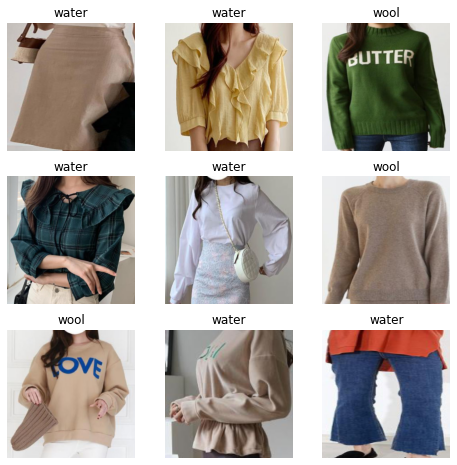

In [12]:
###########################
classes=["water",
        "wool",
        "dry cleaning",
        "etc"] 

# y=train_dataset[18][1] #dict의 18번째 label-->label 값을 뜻한다
figure = plt.figure(figsize=(8,8))
cols, rows= 3,3

for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_dataset),size=(1,)).item()
    
    img, label= train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    title=classes[label]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

# print(classes[2])
# predicted, actual = classes[preds[0].argmax(0)], classes[y]

In [15]:
BATCH_SIZE = 64 #32 작은 것보다 오히려 큰게 나을수도
EPOCHS =10
LOG_INTERVAL=35 #100
LEARNING_RATE=0.001 #0.001
# SAVE_DIR="./results"

device=torch.device("cuda") # if torch.cuda.is_available() else "cpu"

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

model = Resnet50(num_classes=4).cuda() #gpu
# model = Resnet50(num_classes=28).cuda() #gpu
# model = Resnet50(num_classes=28)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)

        # num_label=labels.tolist()[0]     
        # num_pred=preds.tolist()[0]
        # plt.imshow(inputs[0].permute(1,2,0))
        # plt.show()
        # print(f"Label: {num_label}, Class: {classes[num_label]}, pred: {num_pred}, Class_pred: {classes[num_pred]}")

        loss=criterion(outs, labels)

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            torch.save(model.state_dict(), f"{save_dir}/{idx}.pth")
            loss_value = 0
            matches = 0
            
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() #검증 모드,검증 목적은 최적의 epoch를 찾아 overfiting과 unseen data 문제 를 막는 것
        val_loss_items=[]
        val_acc_items=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)
        
        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            torch.save(model.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        
        torch.save(model.state_dict(),f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

 10%|▉         | 34/350 [12:36<1:58:08, 22.43s/it]

Epoch[0/10](35/350) || training loss 1.222 || training accuracy 54.29%


 20%|█▉        | 69/350 [24:32<1:29:18, 19.07s/it]

Epoch[0/10](70/350) || training loss 1.088 || training accuracy 54.11%


 30%|██▉       | 104/350 [35:21<1:11:38, 17.47s/it]

Epoch[0/10](105/350) || training loss 0.9062 || training accuracy 54.37%


 40%|███▉      | 139/350 [45:32<1:00:10, 17.11s/it]

Epoch[0/10](140/350) || training loss 0.8937 || training accuracy 56.21%


 50%|████▉     | 174/350 [54:36<44:07, 15.04s/it]

Epoch[0/10](175/350) || training loss 0.8874 || training accuracy 56.29%


 60%|█████▉    | 209/350 [1:03:18<34:02, 14.49s/it]

Epoch[0/10](210/350) || training loss 0.9046 || training accuracy 57.23%


 70%|██████▉   | 244/350 [1:11:14<23:17, 13.18s/it]

Epoch[0/10](245/350) || training loss 0.8617 || training accuracy 58.21%


 80%|███████▉  | 279/350 [1:18:22<13:23, 11.31s/it]

Epoch[0/10](280/350) || training loss 0.8609 || training accuracy 58.71%


 90%|████████▉ | 314/350 [1:24:54<06:32, 10.90s/it]

Epoch[0/10](315/350) || training loss 0.8474 || training accuracy 58.93%


100%|█████████▉| 349/350 [1:30:41<00:09,  9.87s/it]

Epoch[0/10](350/350) || training loss 0.8444 || training accuracy 61.12%


100%|██████████| 350/350 [1:30:51<00:00, 15.58s/it]


Calculating validation results...


100%|██████████| 88/88 [22:00<00:00, 15.01s/it]


New best model for val accuracy : 57.12%! saving the best model..
[Val] acc : 57.12%, loss: 0.87 || best acc : 57.12%, best loss: 0.87


 10%|▉         | 34/350 [00:56<08:37,  1.64s/it]

Epoch[1/10](35/350) || training loss 0.8061 || training accuracy 61.88%


 20%|█▉        | 69/350 [01:54<07:43,  1.65s/it]

Epoch[1/10](70/350) || training loss 0.8182 || training accuracy 63.17%


 30%|██▉       | 104/350 [02:53<06:55,  1.69s/it]

Epoch[1/10](105/350) || training loss 0.8169 || training accuracy 61.96%


 40%|███▉      | 139/350 [03:53<05:55,  1.68s/it]

Epoch[1/10](140/350) || training loss 0.8005 || training accuracy 63.04%


 50%|████▉     | 174/350 [04:52<04:56,  1.69s/it]

Epoch[1/10](175/350) || training loss 0.7978 || training accuracy 63.93%


 60%|█████▉    | 209/350 [05:51<03:51,  1.64s/it]

Epoch[1/10](210/350) || training loss 0.8059 || training accuracy 64.06%


 70%|██████▉   | 244/350 [06:49<02:53,  1.63s/it]

Epoch[1/10](245/350) || training loss 0.8129 || training accuracy 62.86%


 80%|███████▉  | 279/350 [07:48<01:59,  1.68s/it]

Epoch[1/10](280/350) || training loss 0.8186 || training accuracy 63.57%


 90%|████████▉ | 314/350 [08:47<01:00,  1.68s/it]

Epoch[1/10](315/350) || training loss 0.8123 || training accuracy 62.95%


100%|█████████▉| 349/350 [09:47<00:01,  1.70s/it]

Epoch[1/10](350/350) || training loss 0.8014 || training accuracy 63.53%


100%|██████████| 350/350 [09:49<00:00,  1.68s/it]


Calculating validation results...


100%|██████████| 88/88 [01:50<00:00,  1.26s/it]


New best model for val accuracy : 57.30%! saving the best model..
[Val] acc : 57.30%, loss: 0.97 || best acc : 57.30%, best loss: 0.87


 10%|▉         | 34/350 [00:57<08:53,  1.69s/it]

Epoch[2/10](35/350) || training loss 0.7975 || training accuracy 65.54%


 20%|█▉        | 69/350 [01:56<07:56,  1.70s/it]

Epoch[2/10](70/350) || training loss 0.7506 || training accuracy 66.83%


 30%|██▉       | 104/350 [02:56<06:57,  1.70s/it]

Epoch[2/10](105/350) || training loss 0.7779 || training accuracy 65.85%


 40%|███▉      | 139/350 [03:55<05:55,  1.69s/it]

Epoch[2/10](140/350) || training loss 0.8227 || training accuracy 62.41%


 50%|████▉     | 174/350 [04:53<04:48,  1.64s/it]

Epoch[2/10](175/350) || training loss 0.8027 || training accuracy 63.84%


 60%|█████▉    | 209/350 [05:52<03:55,  1.67s/it]

Epoch[2/10](210/350) || training loss 0.7154 || training accuracy 67.32%


 70%|██████▉   | 244/350 [06:51<02:56,  1.66s/it]

Epoch[2/10](245/350) || training loss 0.7841 || training accuracy 65.80%


 80%|███████▉  | 279/350 [07:51<02:00,  1.69s/it]

Epoch[2/10](280/350) || training loss 0.7702 || training accuracy 66.21%


 90%|████████▉ | 314/350 [08:50<00:58,  1.63s/it]

Epoch[2/10](315/350) || training loss 0.7773 || training accuracy 64.73%


100%|█████████▉| 349/350 [09:47<00:01,  1.65s/it]

Epoch[2/10](350/350) || training loss 0.7534 || training accuracy 66.38%


100%|██████████| 350/350 [09:49<00:00,  1.68s/it]


Calculating validation results...


100%|██████████| 88/88 [01:50<00:00,  1.26s/it]


New best model for val accuracy : 59.72%! saving the best model..
[Val] acc : 59.72%, loss: 0.84 || best acc : 59.72%, best loss: 0.84


 10%|▉         | 34/350 [00:57<08:49,  1.68s/it]

Epoch[3/10](35/350) || training loss 0.7448 || training accuracy 67.68%


 20%|█▉        | 69/350 [01:56<07:42,  1.65s/it]

Epoch[3/10](70/350) || training loss 0.7636 || training accuracy 66.74%


 30%|██▉       | 104/350 [02:53<06:40,  1.63s/it]

Epoch[3/10](105/350) || training loss 0.759 || training accuracy 66.96%


 40%|███▉      | 139/350 [03:52<05:55,  1.69s/it]

Epoch[3/10](140/350) || training loss 0.7619 || training accuracy 66.03%


 50%|████▉     | 174/350 [04:52<04:59,  1.70s/it]

Epoch[3/10](175/350) || training loss 0.7575 || training accuracy 67.23%


 60%|█████▉    | 209/350 [05:51<03:57,  1.68s/it]

Epoch[3/10](210/350) || training loss 0.7243 || training accuracy 66.29%


 70%|██████▉   | 244/350 [06:51<02:52,  1.63s/it]

Epoch[3/10](245/350) || training loss 0.7697 || training accuracy 67.14%


 80%|███████▉  | 279/350 [07:49<01:57,  1.65s/it]

Epoch[3/10](280/350) || training loss 0.7698 || training accuracy 66.70%


 90%|████████▉ | 314/350 [08:48<00:59,  1.66s/it]

Epoch[3/10](315/350) || training loss 0.765 || training accuracy 65.18%


100%|█████████▉| 349/350 [09:48<00:01,  1.69s/it]

Epoch[3/10](350/350) || training loss 0.7526 || training accuracy 66.25%


100%|██████████| 350/350 [09:50<00:00,  1.69s/it]


Calculating validation results...


100%|██████████| 88/88 [01:50<00:00,  1.26s/it]


New best model for val accuracy : 65.99%! saving the best model..
[Val] acc : 65.99%, loss: 0.76 || best acc : 65.99%, best loss: 0.76


 10%|▉         | 34/350 [00:56<08:40,  1.65s/it]

Epoch[4/10](35/350) || training loss 0.7523 || training accuracy 69.20%


 20%|█▉        | 69/350 [01:55<07:51,  1.68s/it]

Epoch[4/10](70/350) || training loss 0.7296 || training accuracy 67.86%


 30%|██▉       | 104/350 [02:54<06:41,  1.63s/it]

Epoch[4/10](105/350) || training loss 0.7396 || training accuracy 68.35%


 40%|███▉      | 139/350 [03:51<05:43,  1.63s/it]

Epoch[4/10](140/350) || training loss 0.7297 || training accuracy 67.81%


 50%|████▉     | 174/350 [04:49<04:46,  1.63s/it]

Epoch[4/10](175/350) || training loss 0.7599 || training accuracy 65.67%


 60%|█████▉    | 209/350 [05:47<03:47,  1.61s/it]

Epoch[4/10](210/350) || training loss 0.756 || training accuracy 68.17%


 70%|██████▉   | 244/350 [06:44<02:50,  1.61s/it]

Epoch[4/10](245/350) || training loss 0.7374 || training accuracy 67.63%


 80%|███████▉  | 279/350 [07:41<01:55,  1.63s/it]

Epoch[4/10](280/350) || training loss 0.7348 || training accuracy 68.12%


 90%|████████▉ | 314/350 [08:39<00:58,  1.62s/it]

Epoch[4/10](315/350) || training loss 0.7636 || training accuracy 66.12%


100%|█████████▉| 349/350 [09:36<00:01,  1.62s/it]

Epoch[4/10](350/350) || training loss 0.7332 || training accuracy 68.21%


100%|██████████| 350/350 [09:38<00:00,  1.65s/it]


Calculating validation results...


100%|██████████| 88/88 [01:46<00:00,  1.21s/it]


[Val] acc : 56.47%, loss:  1.1 || best acc : 65.99%, best loss: 0.76


 10%|▉         | 34/350 [00:55<08:33,  1.62s/it]

Epoch[5/10](35/350) || training loss 0.6939 || training accuracy 70.98%


 20%|█▉        | 69/350 [01:53<07:40,  1.64s/it]

Epoch[5/10](70/350) || training loss 0.7481 || training accuracy 68.79%


 30%|██▉       | 104/350 [02:50<06:43,  1.64s/it]

Epoch[5/10](105/350) || training loss 0.7143 || training accuracy 69.33%


 40%|███▉      | 139/350 [03:48<05:45,  1.64s/it]

Epoch[5/10](140/350) || training loss 0.7451 || training accuracy 68.84%


 50%|████▉     | 174/350 [04:46<04:46,  1.63s/it]

Epoch[5/10](175/350) || training loss 0.7349 || training accuracy 68.17%


 60%|█████▉    | 209/350 [05:43<03:50,  1.63s/it]

Epoch[5/10](210/350) || training loss 0.7293 || training accuracy 68.75%


 70%|██████▉   | 244/350 [06:41<02:51,  1.62s/it]

Epoch[5/10](245/350) || training loss 0.737 || training accuracy 68.44%


 80%|███████▉  | 279/350 [07:38<01:55,  1.63s/it]

Epoch[5/10](280/350) || training loss 0.7429 || training accuracy 68.12%


 90%|████████▉ | 314/350 [08:36<00:58,  1.64s/it]

Epoch[5/10](315/350) || training loss 0.7406 || training accuracy 67.99%


100%|█████████▉| 349/350 [09:34<00:01,  1.66s/it]

Epoch[5/10](350/350) || training loss 0.7486 || training accuracy 66.74%


100%|██████████| 350/350 [09:36<00:00,  1.65s/it]


Calculating validation results...


100%|██████████| 88/88 [01:46<00:00,  1.21s/it]


New best model for val accuracy : 66.15%! saving the best model..
[Val] acc : 66.15%, loss:  0.8 || best acc : 66.15%, best loss: 0.76


 10%|▉         | 34/350 [00:56<08:32,  1.62s/it]

Epoch[6/10](35/350) || training loss 0.7003 || training accuracy 69.60%


 20%|█▉        | 69/350 [01:54<07:42,  1.65s/it]

Epoch[6/10](70/350) || training loss 0.7213 || training accuracy 69.38%


 30%|██▉       | 104/350 [02:51<06:40,  1.63s/it]

Epoch[6/10](105/350) || training loss 0.7162 || training accuracy 69.46%


 40%|███▉      | 139/350 [03:49<05:44,  1.63s/it]

Epoch[6/10](140/350) || training loss 0.75 || training accuracy 67.95%


 50%|████▉     | 174/350 [04:47<04:49,  1.64s/it]

Epoch[6/10](175/350) || training loss 0.7389 || training accuracy 66.88%


 60%|█████▉    | 209/350 [05:45<03:52,  1.65s/it]

Epoch[6/10](210/350) || training loss 0.7097 || training accuracy 69.38%


 70%|██████▉   | 244/350 [06:42<02:53,  1.63s/it]

Epoch[6/10](245/350) || training loss 0.6887 || training accuracy 70.18%


 80%|███████▉  | 279/350 [07:40<01:55,  1.62s/it]

Epoch[6/10](280/350) || training loss 0.6815 || training accuracy 69.51%


 90%|████████▉ | 314/350 [08:37<00:59,  1.65s/it]

Epoch[6/10](315/350) || training loss 0.7311 || training accuracy 69.60%


100%|█████████▉| 349/350 [09:35<00:01,  1.64s/it]

Epoch[6/10](350/350) || training loss 0.7126 || training accuracy 69.60%


100%|██████████| 350/350 [09:37<00:00,  1.65s/it]


Calculating validation results...


100%|██████████| 88/88 [01:46<00:00,  1.21s/it]


[Val] acc : 64.98%, loss: 0.79 || best acc : 66.15%, best loss: 0.76


 10%|▉         | 34/350 [00:55<08:38,  1.64s/it]

Epoch[7/10](35/350) || training loss 0.7097 || training accuracy 69.96%


 20%|█▉        | 69/350 [01:53<07:42,  1.65s/it]

Epoch[7/10](70/350) || training loss 0.7109 || training accuracy 69.55%


 30%|██▉       | 104/350 [02:51<06:49,  1.66s/it]

Epoch[7/10](105/350) || training loss 0.6889 || training accuracy 70.76%


 40%|███▉      | 139/350 [03:48<05:48,  1.65s/it]

Epoch[7/10](140/350) || training loss 0.7127 || training accuracy 69.33%


 50%|████▉     | 174/350 [04:46<04:45,  1.62s/it]

Epoch[7/10](175/350) || training loss 0.6916 || training accuracy 70.76%


 60%|█████▉    | 209/350 [05:44<03:49,  1.63s/it]

Epoch[7/10](210/350) || training loss 0.7307 || training accuracy 68.26%


 70%|██████▉   | 244/350 [06:41<02:51,  1.62s/it]

Epoch[7/10](245/350) || training loss 0.7206 || training accuracy 69.02%


 80%|███████▉  | 279/350 [07:38<01:56,  1.64s/it]

Epoch[7/10](280/350) || training loss 0.6798 || training accuracy 69.64%


 90%|████████▉ | 314/350 [08:36<00:58,  1.63s/it]

Epoch[7/10](315/350) || training loss 0.6885 || training accuracy 69.51%


100%|█████████▉| 349/350 [09:34<00:01,  1.61s/it]

Epoch[7/10](350/350) || training loss 0.7215 || training accuracy 69.20%


100%|██████████| 350/350 [09:36<00:00,  1.65s/it]


Calculating validation results...


100%|██████████| 88/88 [01:46<00:00,  1.21s/it]


New best model for val accuracy : 67.03%! saving the best model..
[Val] acc : 67.03%, loss: 0.75 || best acc : 67.03%, best loss: 0.75


 10%|▉         | 34/350 [00:55<08:33,  1.62s/it]

Epoch[8/10](35/350) || training loss 0.6762 || training accuracy 71.03%


 20%|█▉        | 69/350 [01:53<07:42,  1.65s/it]

Epoch[8/10](70/350) || training loss 0.6689 || training accuracy 72.23%


 30%|██▉       | 104/350 [02:51<06:44,  1.64s/it]

Epoch[8/10](105/350) || training loss 0.686 || training accuracy 70.80%


 40%|███▉      | 139/350 [03:48<05:45,  1.64s/it]

Epoch[8/10](140/350) || training loss 0.6954 || training accuracy 70.49%


 50%|████▉     | 174/350 [04:46<04:49,  1.65s/it]

Epoch[8/10](175/350) || training loss 0.7371 || training accuracy 67.72%


 60%|█████▉    | 209/350 [05:45<03:48,  1.62s/it]

Epoch[8/10](210/350) || training loss 0.7129 || training accuracy 68.04%


 70%|██████▉   | 244/350 [06:43<02:54,  1.64s/it]

Epoch[8/10](245/350) || training loss 0.6543 || training accuracy 72.99%


 80%|███████▉  | 279/350 [07:40<01:56,  1.64s/it]

Epoch[8/10](280/350) || training loss 0.6958 || training accuracy 69.87%


 90%|████████▉ | 314/350 [08:38<00:59,  1.64s/it]

Epoch[8/10](315/350) || training loss 0.7003 || training accuracy 69.64%


100%|█████████▉| 349/350 [09:36<00:01,  1.64s/it]

Epoch[8/10](350/350) || training loss 0.6904 || training accuracy 71.07%


100%|██████████| 350/350 [09:38<00:00,  1.65s/it]


Calculating validation results...


100%|██████████| 88/88 [01:47<00:00,  1.23s/it]


[Val] acc : 66.20%, loss: 0.77 || best acc : 67.03%, best loss: 0.75


 10%|▉         | 34/350 [00:56<08:47,  1.67s/it]

Epoch[9/10](35/350) || training loss 0.6554 || training accuracy 71.56%


 20%|█▉        | 69/350 [01:54<07:47,  1.66s/it]

Epoch[9/10](70/350) || training loss 0.6489 || training accuracy 71.88%


 30%|██▉       | 104/350 [02:52<06:52,  1.68s/it]

Epoch[9/10](105/350) || training loss 0.6863 || training accuracy 70.54%


 40%|███▉      | 139/350 [03:51<05:53,  1.67s/it]

Epoch[9/10](140/350) || training loss 0.646 || training accuracy 73.44%


 50%|████▉     | 174/350 [04:49<04:53,  1.67s/it]

Epoch[9/10](175/350) || training loss 0.6774 || training accuracy 70.98%


 60%|█████▉    | 209/350 [05:48<03:49,  1.63s/it]

Epoch[9/10](210/350) || training loss 0.6963 || training accuracy 69.82%


 70%|██████▉   | 244/350 [06:46<02:56,  1.67s/it]

Epoch[9/10](245/350) || training loss 0.6862 || training accuracy 71.88%


 80%|███████▉  | 279/350 [07:44<01:57,  1.65s/it]

Epoch[9/10](280/350) || training loss 0.691 || training accuracy 70.76%


 90%|████████▉ | 314/350 [08:42<01:00,  1.67s/it]

Epoch[9/10](315/350) || training loss 0.6757 || training accuracy 71.70%


100%|█████████▉| 349/350 [09:41<00:01,  1.67s/it]

Epoch[9/10](350/350) || training loss 0.6794 || training accuracy 70.58%


100%|██████████| 350/350 [09:43<00:00,  1.67s/it]


Calculating validation results...


100%|██████████| 88/88 [01:48<00:00,  1.23s/it]


[Val] acc : 63.35%, loss: 0.85 || best acc : 67.03%, best loss: 0.75


In [14]:
torch.cuda.empty_cache()